In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.utils import resample
from joblib import Parallel, delayed
from tqdm import tqdm


import time


# 1 Task: Make_blobs = df1

Corr Matrix:
           feature1  feature2  feature3  feature4  feature5  feature6  \
feature1   1.000000  0.988566  0.988916  0.988201  0.988410  0.988863   
feature2   0.988566  1.000000  0.988675  0.988948  0.988519  0.988631   
feature3   0.988916  0.988675  1.000000  0.988597  0.988351  0.988907   
feature4   0.988201  0.988948  0.988597  1.000000  0.988204  0.988724   
feature5   0.988410  0.988519  0.988351  0.988204  1.000000  0.988617   
feature6   0.988863  0.988631  0.988907  0.988724  0.988617  1.000000   
feature7   0.988708  0.988796  0.988622  0.988304  0.988249  0.988879   
feature8   0.988342  0.988397  0.988173  0.988766  0.988504  0.988815   
feature9   0.988688  0.988967  0.988397  0.988999  0.988572  0.988767   
feature10  0.988655  0.988707  0.988595  0.988968  0.989007  0.988835   
feature11  0.988441  0.988065  0.988171  0.988375  0.988381  0.988328   
feature12  0.988337  0.988457  0.988930  0.988483  0.988230  0.988663   
feature13  0.988327  0.988397  0.98860

Bootstrap progress:  71%|███████▏  | 1071/1500 [13:16<05:19,  1.34it/s]


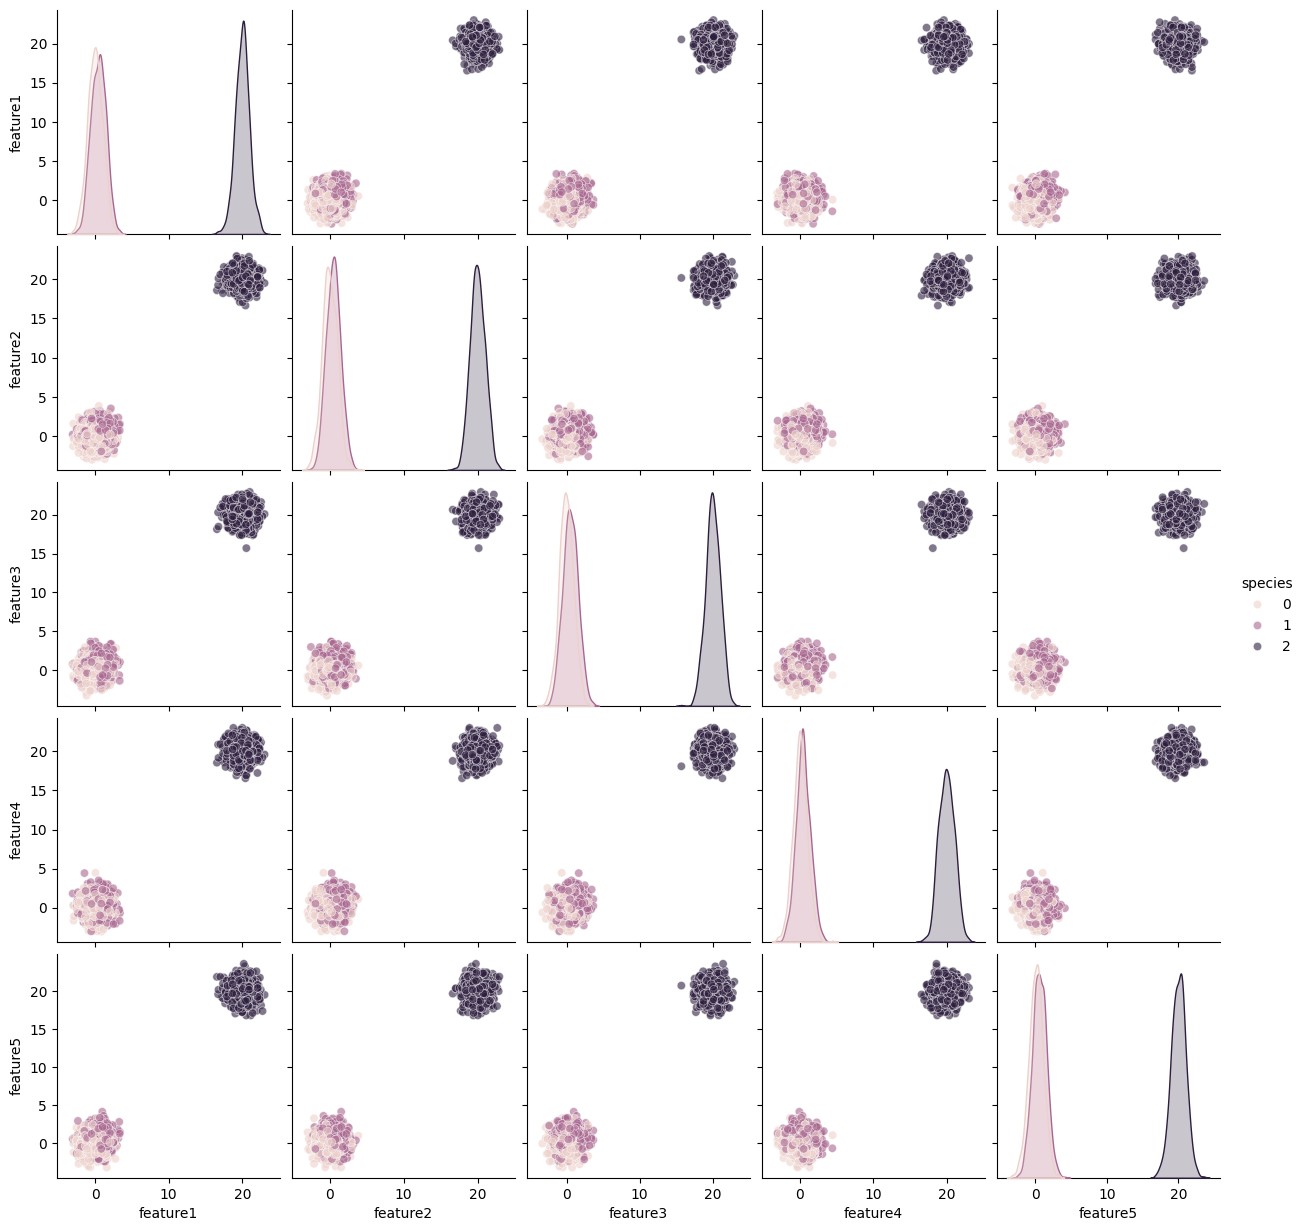

In [25]:
n_samples = 1000
n_features = 16
centers = np.array([
    np.zeros(n_features),
    np.ones(n_features) * 0.5,
    np.ones(n_features) * 20
])

x, y = make_blobs(
    n_samples=[n_samples, n_samples, n_samples],
    centers=centers,
    n_features=n_features,
    cluster_std=[1.0, 1.0, 1.0],
    random_state=42
)

feature_names = [f'feature{i+1}' for i in range(n_features)]
df1 = pd.DataFrame(x, columns=feature_names)
df1['species'] = y

corr_matrix = df1[feature_names].corr()
print('Corr Matrix:')
print(corr_matrix)

selected_features = feature_names[:5]

sns.pairplot(
    data=df1,
    vars=selected_features,
    hue='species',
    plot_kws={'alpha': 0.6},
    diag_kind='kde',
)

plt.show()



# 2 Task: Oversample DFs

In [26]:
def oversample_class(df, target_class, repeat_list, class_col='species'):
    """
    Создает несколько датасетов, где целый класс повторяется разное количество раз.
    
    Parameters:
        df: исходный DataFrame
        target_class: класс, который нужно увеличивать
        repeat_list: список множителей (например [2,5,10,...])
        class_col: название колонки с классами
    Returns:
        dict: ключи - df2, df5,..., значения - новые DataFrame
    """
    dfs = {}
    
    # Разделяем на "увеличиваемый" и остальные
    df_target = df[df[class_col] == target_class]
    df_rest = df[df[class_col] != target_class]
    
    for r in repeat_list:
        df_new = pd.concat([df_target]*r + [df_rest], ignore_index=True)
        dfs[f'df{r}'] = df_new
    
    return dfs

repeat_list = [2, 5, 10, 20, 50, 100, 1000, 10000]
target_class = 0  # например, класс 0, который пересекается с другим
oversampled_datasets = oversample_class(df1, target_class, repeat_list)

# Проверка размеров
for name, df in oversampled_datasets.items():
    print(name, df.shape)

# oversampled_datasets['df50'].head()

df2 (4000, 17)
df5 (7000, 17)
df10 (12000, 17)
df20 (22000, 17)
df50 (52000, 17)
df100 (102000, 17)
df1000 (1002000, 17)
df10000 (10002000, 17)


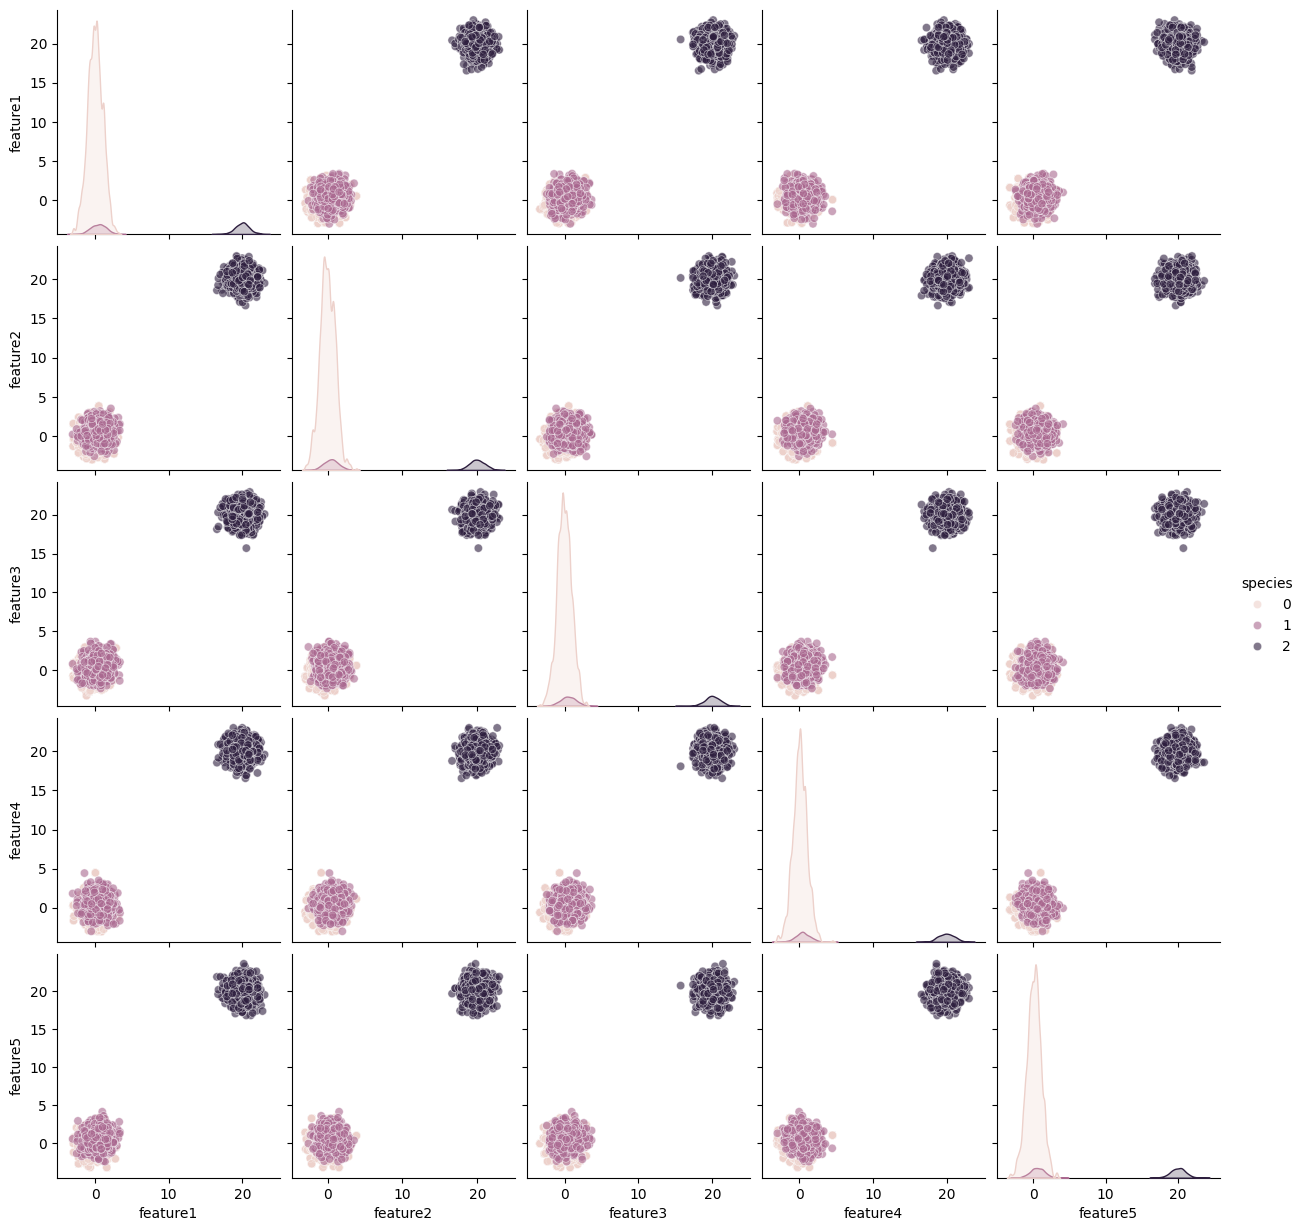

In [27]:
sns.pairplot(
    data=oversampled_datasets['df20'],
    vars=selected_features,
    hue='species',
    plot_kws={'alpha': 0.6},
    diag_kind='kde',
)

# 3-5 Task: LDA 

In [28]:
def bootstrap_curve(y_true, scores, n_boot=1000, grid_len=200, curve_type='roc', random_state=42, n_jobs=-1):
    """
    Построение ROC или PR кривой с бутстрэпом и прогресс-баром tqdm.
    """
    rng = np.random.RandomState(random_state)
    n_samples = len(y_true)

    grid = np.linspace(0, 1, grid_len)
    tprs_boot = np.zeros((n_boot, grid_len))
    aucs_boot = np.zeros(n_boot)

    def one_boot(i):
        idx = rng.randint(0, n_samples, n_samples)
        if len(np.unique(y_true[idx])) < 2:
            return np.zeros(grid_len), np.nan
        y_b = y_true[idx]
        s_b = scores[idx]
        if curve_type == 'roc':
            fpr_b, tpr_b, _ = roc_curve(y_b, s_b)
            auc_b = auc(fpr_b, tpr_b)
            tpr_interp = np.interp(grid, fpr_b, tpr_b)
        else:
            precision_b, recall_b, _ = precision_recall_curve(y_b, s_b)
            auc_b = average_precision_score(y_b, s_b)
            tpr_interp = np.interp(grid, recall_b[::-1], precision_b[::-1])
        return tpr_interp, auc_b

    # Используем tqdm с Parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(one_boot)(i) for i in tqdm(range(n_boot), desc="Bootstrap progress")
    )

    for i, (tpr_interp, auc_b) in enumerate(results):
        tprs_boot[i, :] = tpr_interp
        aucs_boot[i] = auc_b

    valid_aucs = aucs_boot[~np.isnan(aucs_boot)]
    auc_ci = (np.nan, np.nan) if valid_aucs.size==0 else (np.percentile(valid_aucs,2.5), np.percentile(valid_aucs,97.5))
    tprs_valid = tprs_boot[~np.isnan(aucs_boot), :]
    tpr_lower = np.zeros_like(grid) if tprs_valid.size==0 else np.percentile(tprs_valid,2.5,axis=0)
    tpr_upper = np.zeros_like(grid) if tprs_valid.size==0 else np.percentile(tprs_valid,97.5,axis=0)

    return {
        'grid': grid,
        'tprs_boot': tprs_boot,
        'tpr_lower': tpr_lower,
        'tpr_upper': tpr_upper,
        'auc_ci': auc_ci,
        'aucs_boot': aucs_boot
    }

def analyze_lda(
    df,
    class_pair=(0,1),
    features=('feature1', 'feature2'),
    target_class=None,
    n_boot=1000,
    fpr_grid_len=200,
    random_state=42,
    figsize=(14,6),
    show=True,
    n_jobs=-1
):
    """
    LDA анализ с визуализацией пространства, ROC и PR кривых с бутстрэп CI.

    Параметры:
        df: DataFrame с признаками и 'species'
        class_pair: кортеж классов для анализа
        features: пара признаков для визуализации
        target_class: класс для бинарной ROC/PR
        n_boot: количество бутстрэп итераций
        fpr_grid_len: сетка для интерполяции
        n_jobs: параллельные процессы для бутстрэпа
    """
    np.random.seed(random_state)
    if target_class is None:
        target_class = class_pair[0]

    df2 = df[df['species'].isin(class_pair)].copy()
    if df2.empty:
        raise ValueError("После фильтрации DataFrame пуст. Проверьте class_pair.")

    X = df2[list(features)].values
    y = df2['species'].values
    y_bin = (y == target_class).astype(int)

    lda = LinearDiscriminantAnalysis()
    t0 = time.time()
    lda.fit(X, y_bin)
    lda_time = time.time() - t0

    # Решающее поле
    x_min, x_max = X[:,0].min() - 1.0, X[:,0].max() + 1.0
    y_min, y_max = X[:,1].min() - 1.0, X[:,1].max() + 1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    try:
        Z = lda.decision_function(grid)
    except:
        Z = lda.predict_proba(grid)[:,1]
    Z = Z.reshape(xx.shape)

    # Центры классов
    centers = {}
    for cls in class_pair:
        Xc = df2[df2['species']==cls][list(features)].values
        centers[f'class_{cls}'] = Xc.mean(axis=0)
    centers['global_center'] = np.vstack([centers[f'class_{c}'] for c in class_pair]).mean(axis=0)
    centers['segment_mid'] = (centers[f'class_{class_pair[0]}'] + centers[f'class_{class_pair[1]}']) / 2.0

    # Scores для ROC/PR
    try:
        scores = lda.decision_function(X)
    except:
        scores = lda.predict_proba(X)[:,1]

    roc_result = bootstrap_curve(y_bin, scores, n_boot=n_boot, grid_len=fpr_grid_len, curve_type='roc', random_state=random_state, n_jobs=n_jobs)
    pr_result = bootstrap_curve(y_bin, scores, n_boot=n_boot, grid_len=fpr_grid_len, curve_type='pr', random_state=random_state, n_jobs=n_jobs)

    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    ax0, ax1 = axes

    # Левая: LDA пространство
    ax0.contourf(xx, yy, Z > 0, levels=[-1,0,1], colors=["#f86969","#8bff8b"], alpha=0.3) 
    ax0.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles='--', colors='black')  # решающая линия
    colors = {class_pair[0]:'C0', class_pair[1]:'C1'}

    for cls in class_pair:
        sel = df2['species']==cls
        color = 'green' if cls == target_class else 'red'
        ax0.scatter(df2.loc[sel, features[0]], df2.loc[sel, features[1]],
                    s=30, alpha=0.7, label=f'class {cls}', color=color)
    # центры и линия
    c0, c1 = centers[f'class_{class_pair[0]}'], centers[f'class_{class_pair[1]}']
    ax0.scatter([c0[0]], [c0[1]], s=120, marker='X', edgecolor='k', linewidth=1.2)
    ax0.scatter([c1[0]], [c1[1]], s=120, marker='X', edgecolor='k', linewidth=1.2)
    ax0.plot([c0[0], c1[0]], [c0[1], c1[1]], linestyle='-', linewidth=2, alpha=0.7)
    mid = (c0+c1)/2
    ax0.scatter([mid[0]], [mid[1]], s=80, marker='o', facecolors='none', edgecolor='k')

    ax0.set_xlabel(features[0])
    ax0.set_ylabel(features[1])
    ax0.set_title('LDA decision regions + data')
    ax0.legend()
    ax0.grid(True, alpha=0.2)
    ax0.text(0.01, 0.99, f'LDA fit time: {lda_time:.4f} s', transform=ax0.transAxes,
             verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    # Правая: ROC + PR кривые
    ax1.plot(roc_result['grid'], roc_result['tprs_boot'].mean(axis=0), lw=2, label=f'ROC mean AUC = {roc_result["aucs_boot"].mean():.3f}')
    ax1.fill_between(roc_result['grid'], roc_result['tpr_lower'], roc_result['tpr_upper'], alpha=0.25, label='ROC 95% CI')
    ax1.plot(pr_result['grid'], pr_result['tprs_boot'].mean(axis=0), lw=2, color='orange', label=f'PR mean AUPRC = {pr_result["aucs_boot"].mean():.3f}')
    ax1.fill_between(pr_result['grid'], pr_result['tpr_lower'], pr_result['tpr_upper'], alpha=0.15, color='orange', label='PR 95% CI')
    ax1.plot([0,1],[0,1], linestyle='--', color='grey', linewidth=1)
    ax1.set_xlabel('FPR / Recall')
    ax1.set_ylabel('TPR / Precision')
    ax1.set_title(f'ROC & PR curves (target class = {target_class})')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.2)

    if show:
        plt.tight_layout()
        plt.show()

    return {
        'fig': fig,
        'lda_time': lda_time,
        'centers': centers,
        'roc_result': roc_result,
        'pr_result': pr_result
    }


=== Анализ для df2 ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 10175.67it/s]


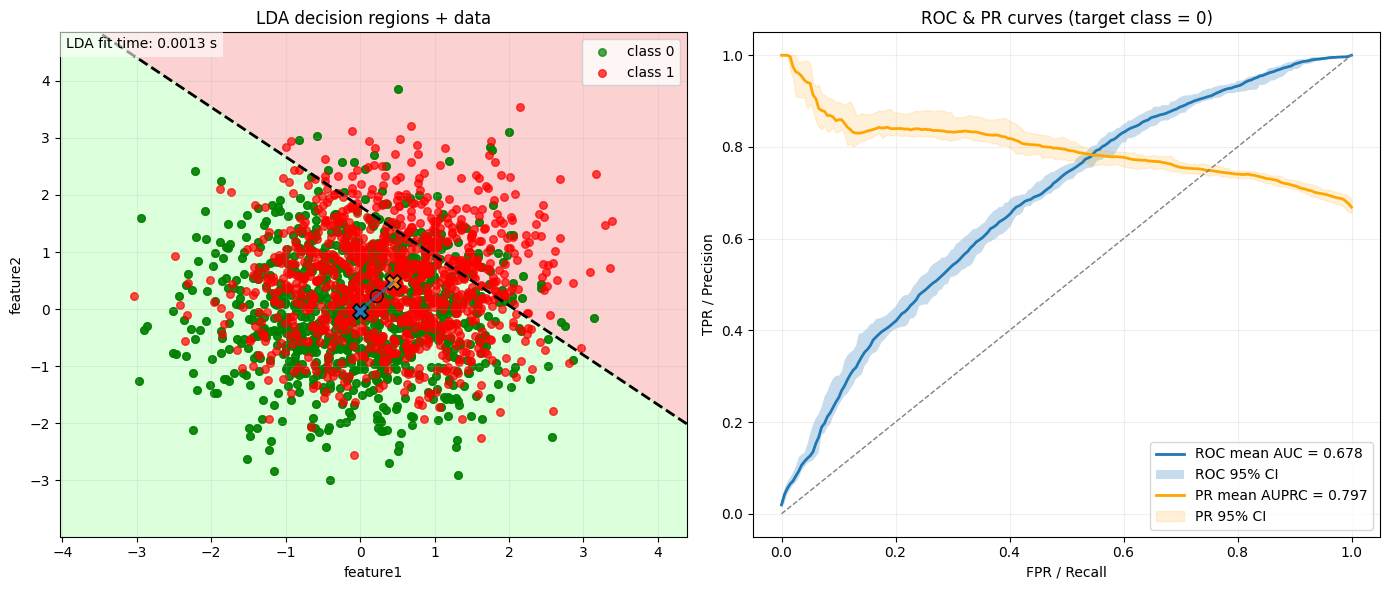

ROC AUC = 0.678, CI95 = [0.668, 0.695]
PR AUPRC = 0.797, CI95 = [0.786, 0.818]

=== Анализ для df5 ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 8886.41it/s]


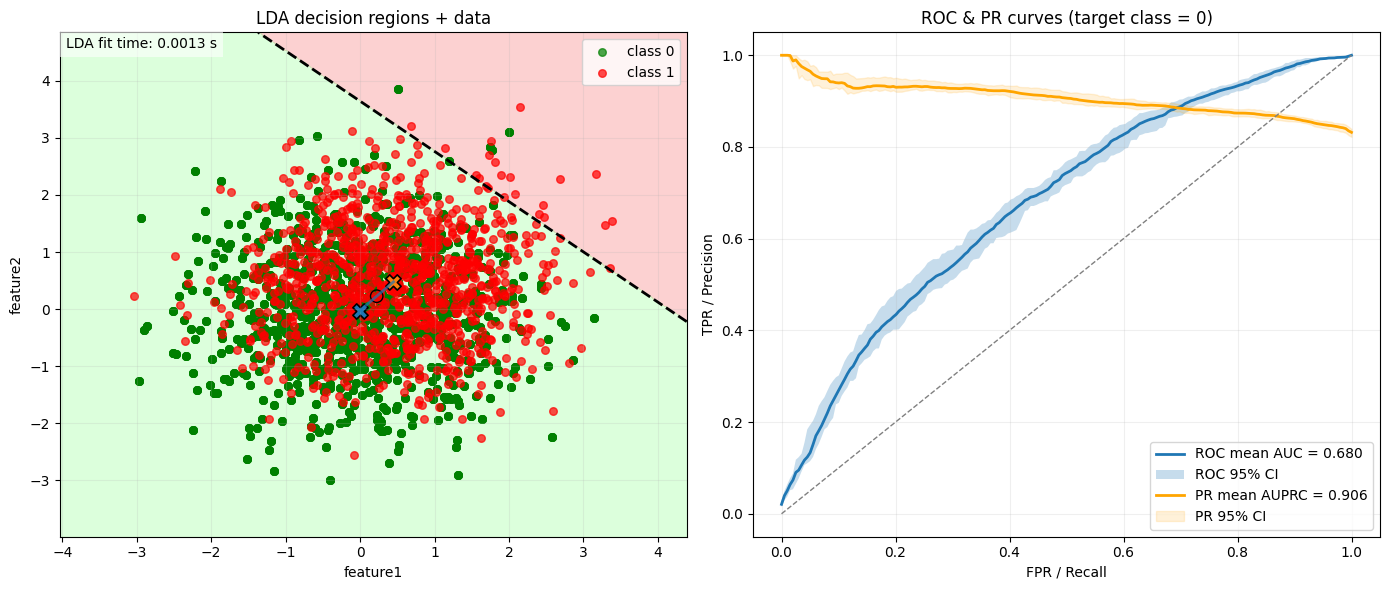

ROC AUC = 0.680, CI95 = [0.658, 0.699]
PR AUPRC = 0.906, CI95 = [0.898, 0.917]

=== Анализ для df10 ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 7158.43it/s]


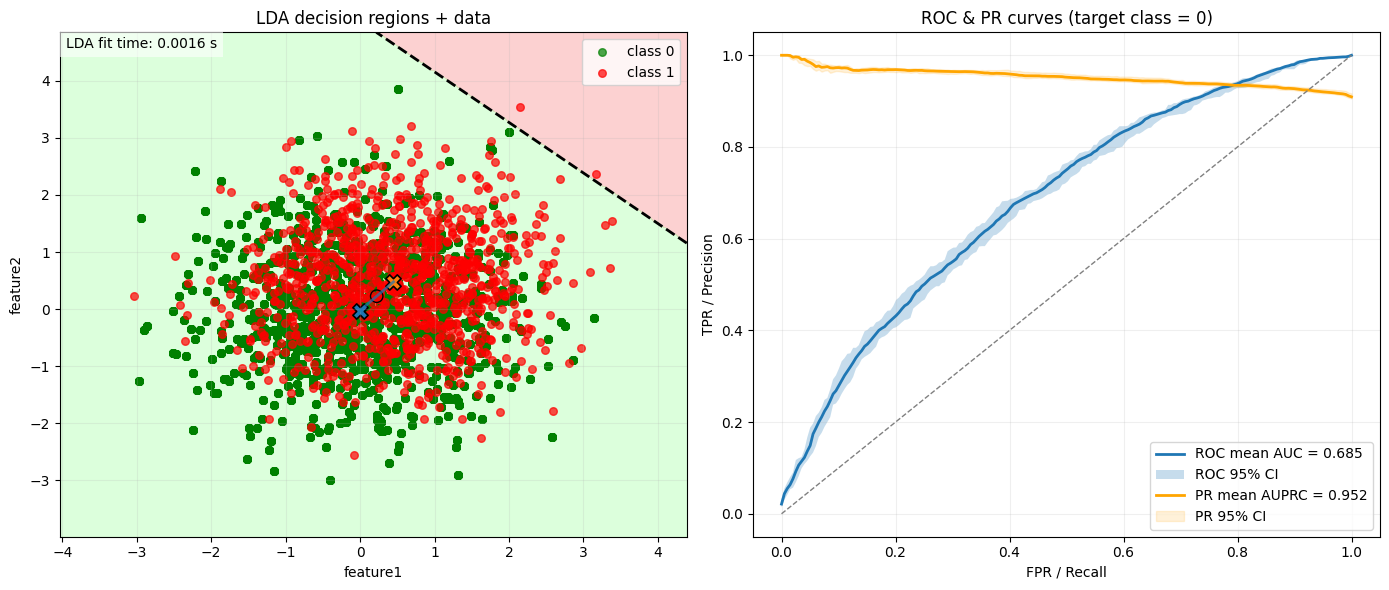

ROC AUC = 0.685, CI95 = [0.674, 0.695]
PR AUPRC = 0.952, CI95 = [0.950, 0.957]

=== Анализ для df20 ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 4743.39it/s]


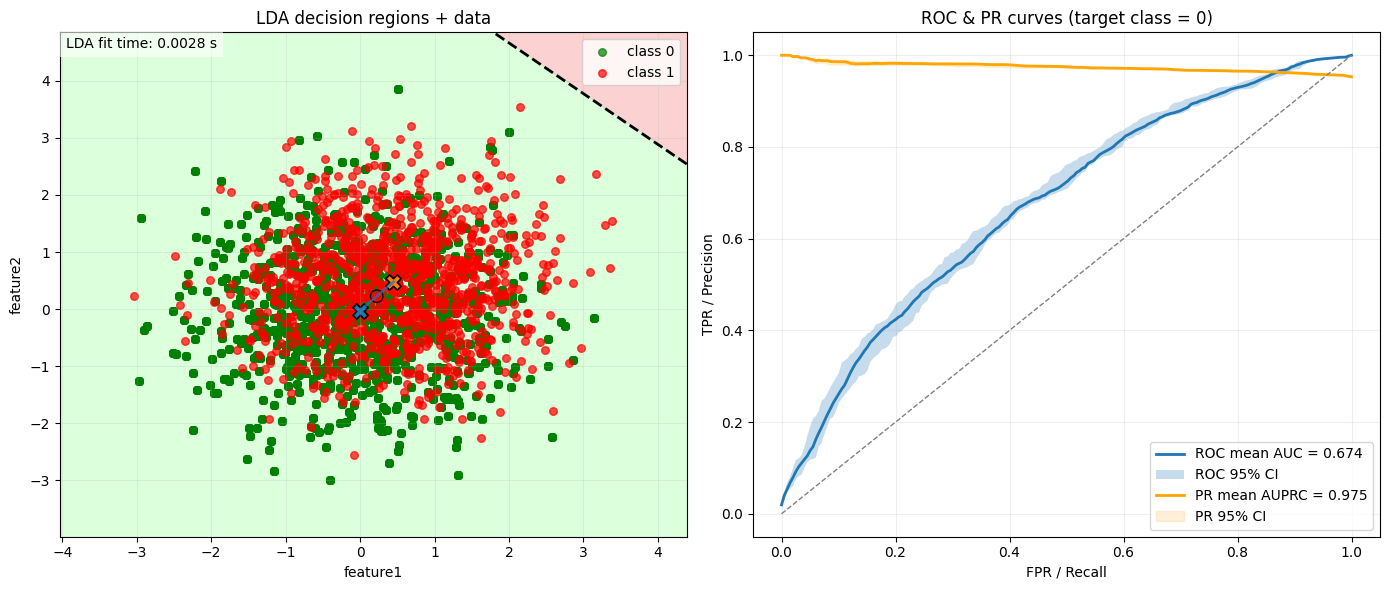

ROC AUC = 0.674, CI95 = [0.665, 0.689]
PR AUPRC = 0.975, CI95 = [0.972, 0.977]

=== Анализ для df50 ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 1729.73it/s]


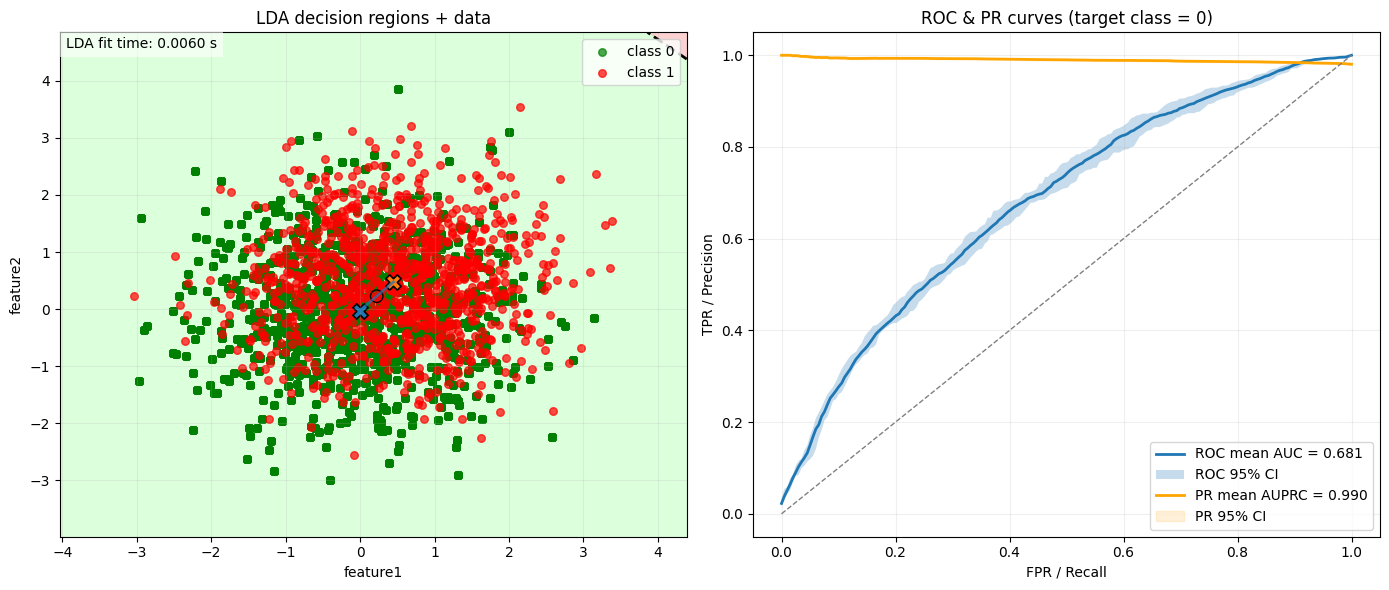

ROC AUC = 0.681, CI95 = [0.667, 0.695]
PR AUPRC = 0.990, CI95 = [0.989, 0.991]

=== Анализ для df100 ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:02<00:00, 619.19it/s]


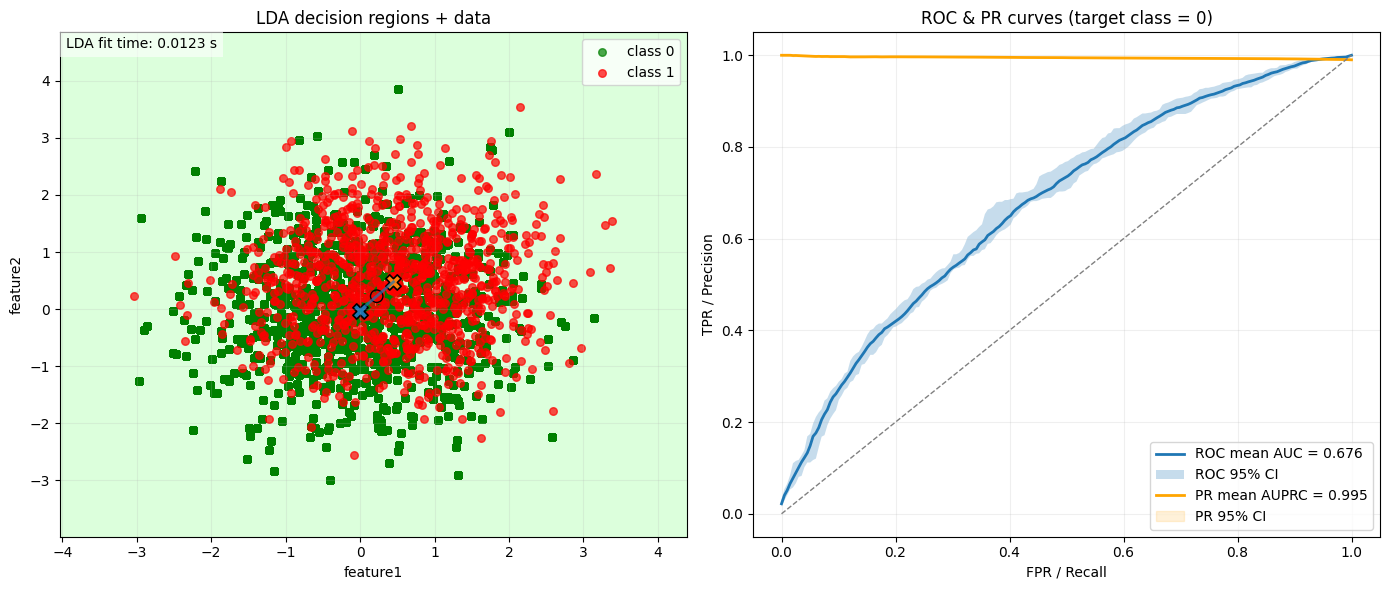

ROC AUC = 0.676, CI95 = [0.666, 0.698]
PR AUPRC = 0.995, CI95 = [0.994, 0.995]

=== Анализ для df1000 ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:37<00:00, 40.30it/s]


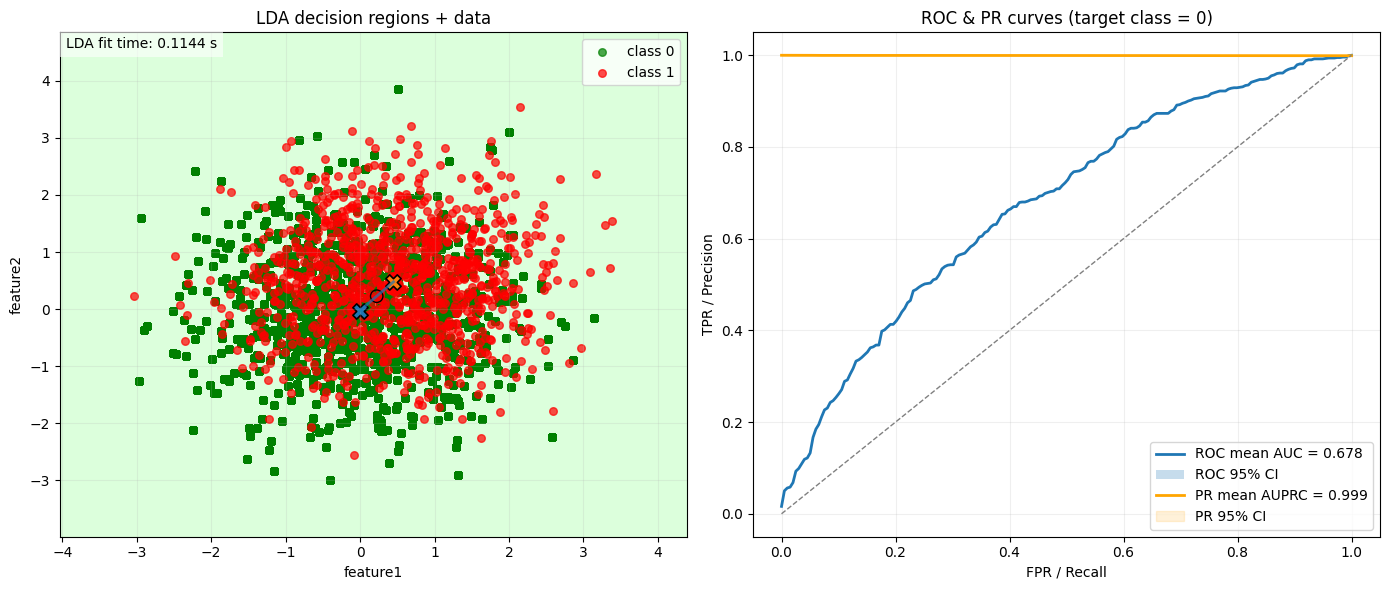

ROC AUC = 0.678, CI95 = [0.678, 0.678]
PR AUPRC = 0.999, CI95 = [0.999, 0.999]

=== Анализ для df10000 ===


Bootstrap progress:  53%|█████▎    | 800/1500 [03:05<02:42,  4.32it/s]Fatal Python error: Segmentation fault

Current thread 0x0000735d7cc10080 (most recent call first):
  File "/home/toasty/repos/tsd/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py", line 57 in _wrapfunc
  File "/home/toasty/repos/tsd/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py", line 1243 in argsort
  File "/home/toasty/repos/tsd/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py", line 886 in _binary_clf_curve
  File "/home/toasty/repos/tsd/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py", line 1163 in roc_curve
  File "/home/toasty/repos/tsd/venv/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 218 in wrapper
  File "/tmp/ipykernel_890/1965327058.py", line 19 in one_boot
  File "/home/toasty/repos/tsd/venv/lib/python3.12/site-packages/joblib/parallel.py", line 607 in __call__
  File "/home/toasty/repos/tsd/venv/lib/python3.12/site-packages/

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGSEGV(-11)}
Detailed tracebacks of the workers should have been printed to stderr in the executor process if faulthandler was not disabled.

In [29]:
for name, dfN in oversampled_datasets.items():
    print(f"\n=== Анализ для {name} ===")
    result = analyze_lda(
        df=dfN,
        class_pair=(0, 1),
        features=('feature1', 'feature2'),
        target_class=0,
        n_boot=1500,        # при очень больших df можно поставить меньше, например 500
        show=True,
        n_jobs=-1           # параллельный бутстрэп
    )
    
    # Численные результаты
    roc_auc_mean = np.mean(result['roc_result']['aucs_boot'])
    roc_ci = result['roc_result']['auc_ci']
    pr_auc_mean = np.mean(result['pr_result']['aucs_boot'])
    pr_ci = result['pr_result']['auc_ci']
    
    print(f"ROC AUC = {roc_auc_mean:.3f}, CI95 = [{roc_ci[0]:.3f}, {roc_ci[1]:.3f}]")
    print(f"PR AUPRC = {pr_auc_mean:.3f}, CI95 = [{pr_ci[0]:.3f}, {pr_ci[1]:.3f}]")



=== Анализ для df2 (target_class = 1) ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 7852.62it/s]


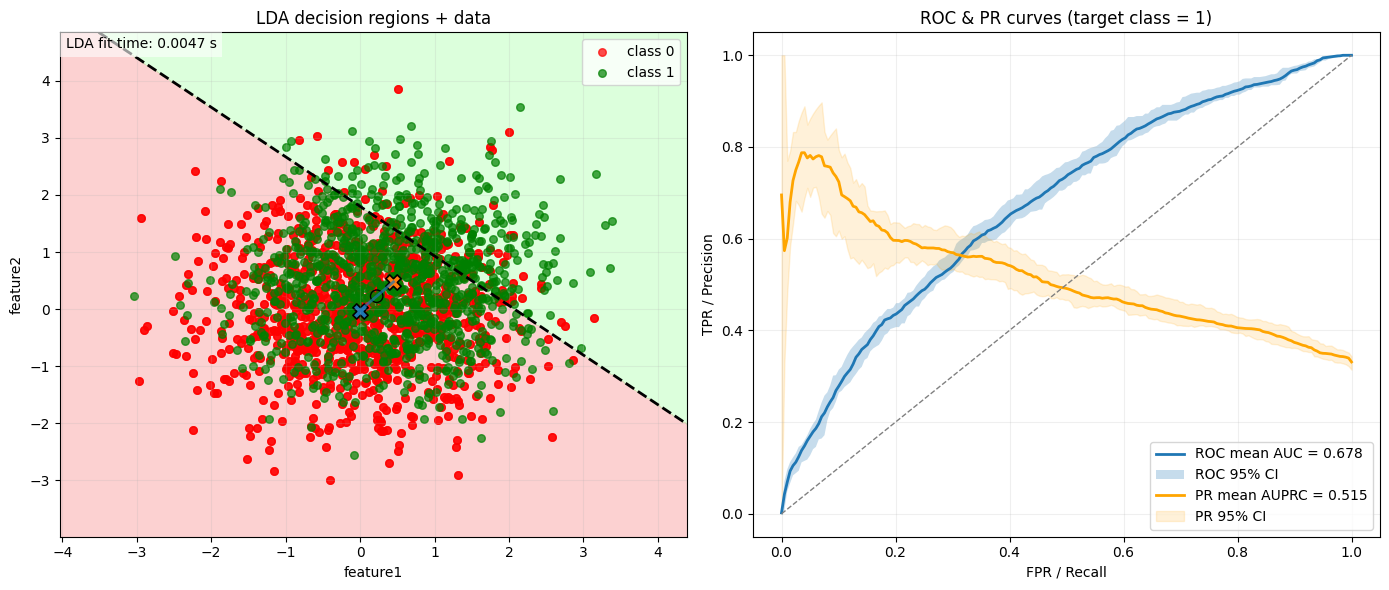


=== Анализ для df5 (target_class = 1) ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 7875.20it/s]


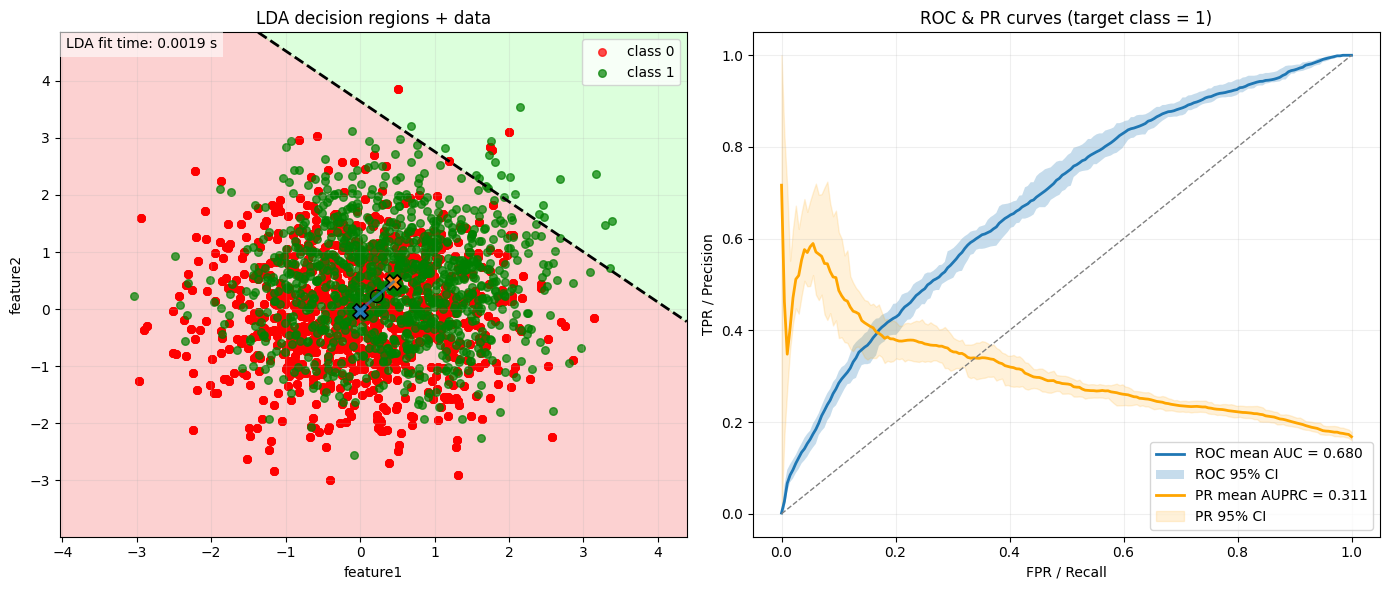


=== Анализ для df10 (target_class = 1) ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 3188.74it/s]


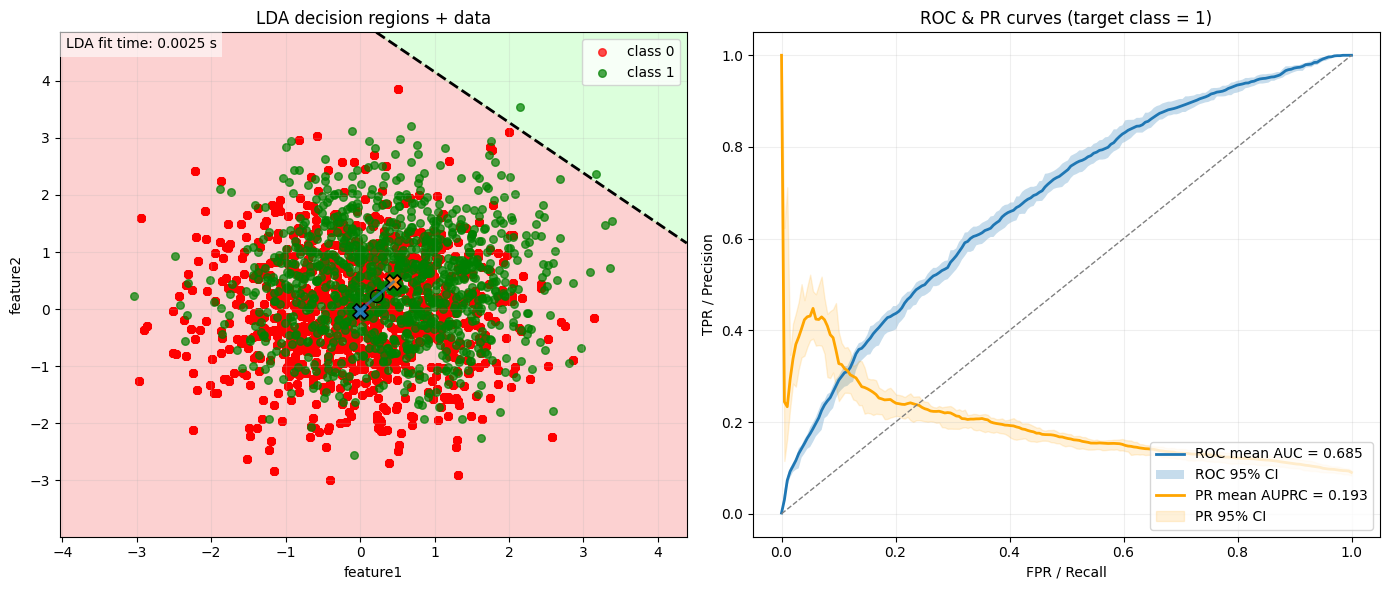


=== Анализ для df20 (target_class = 1) ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 4757.28it/s]


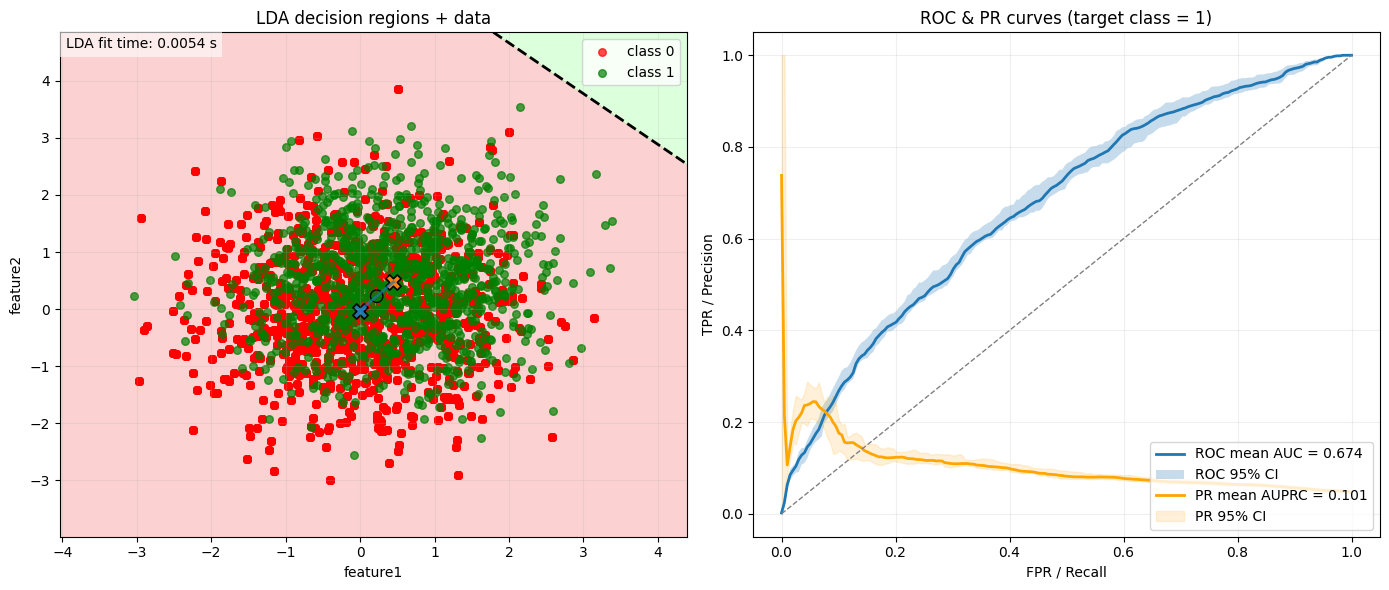


=== Анализ для df50 (target_class = 1) ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 1681.40it/s]


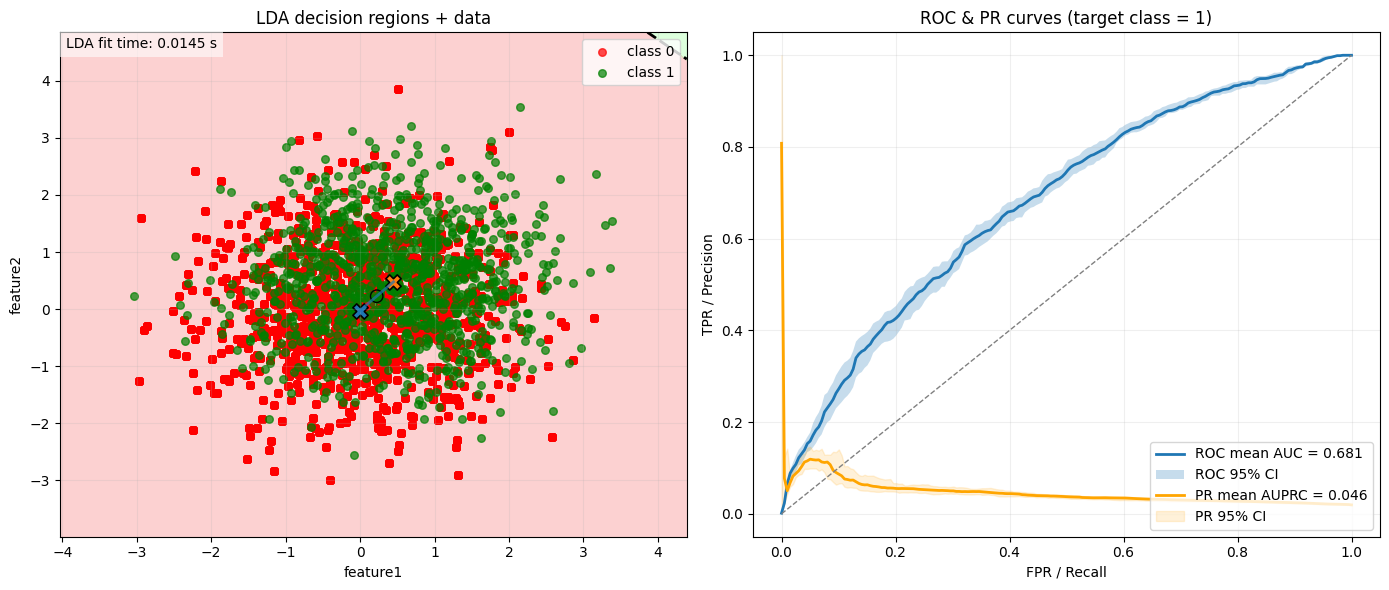


=== Анализ для df100 (target_class = 1) ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:02<00:00, 649.38it/s]


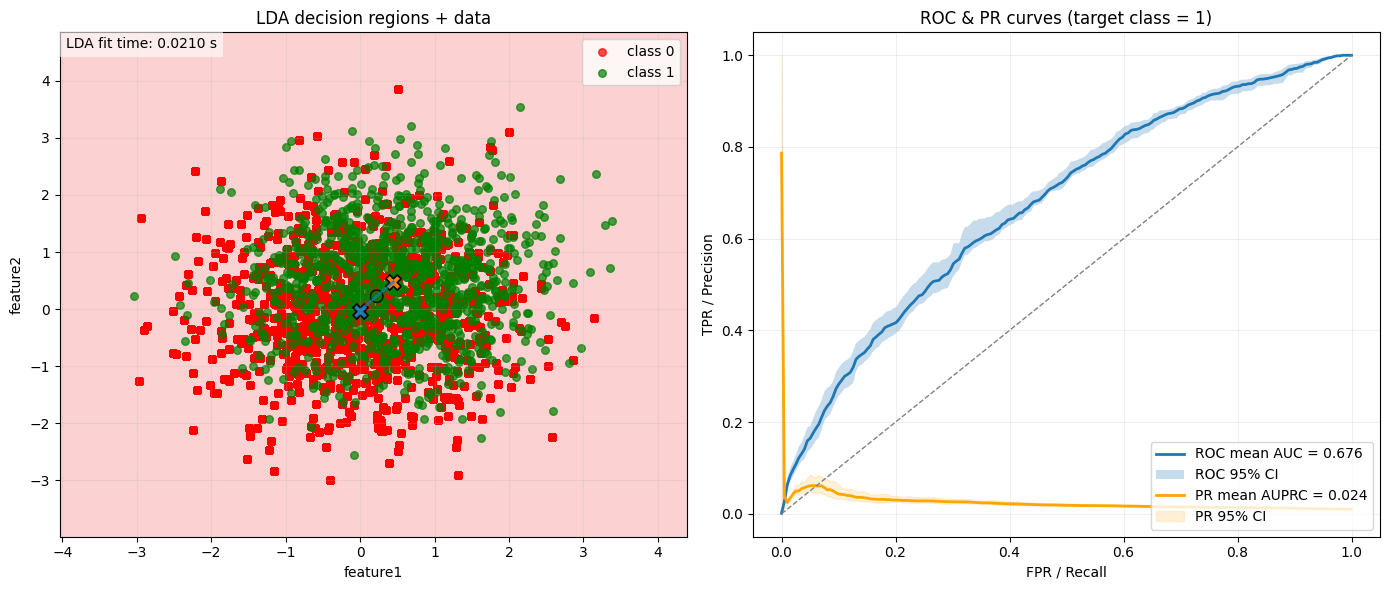


=== Анализ для df1000 (target_class = 1) ===


Bootstrap progress: 100%|██████████| 1500/1500 [00:36<00:00, 40.80it/s]


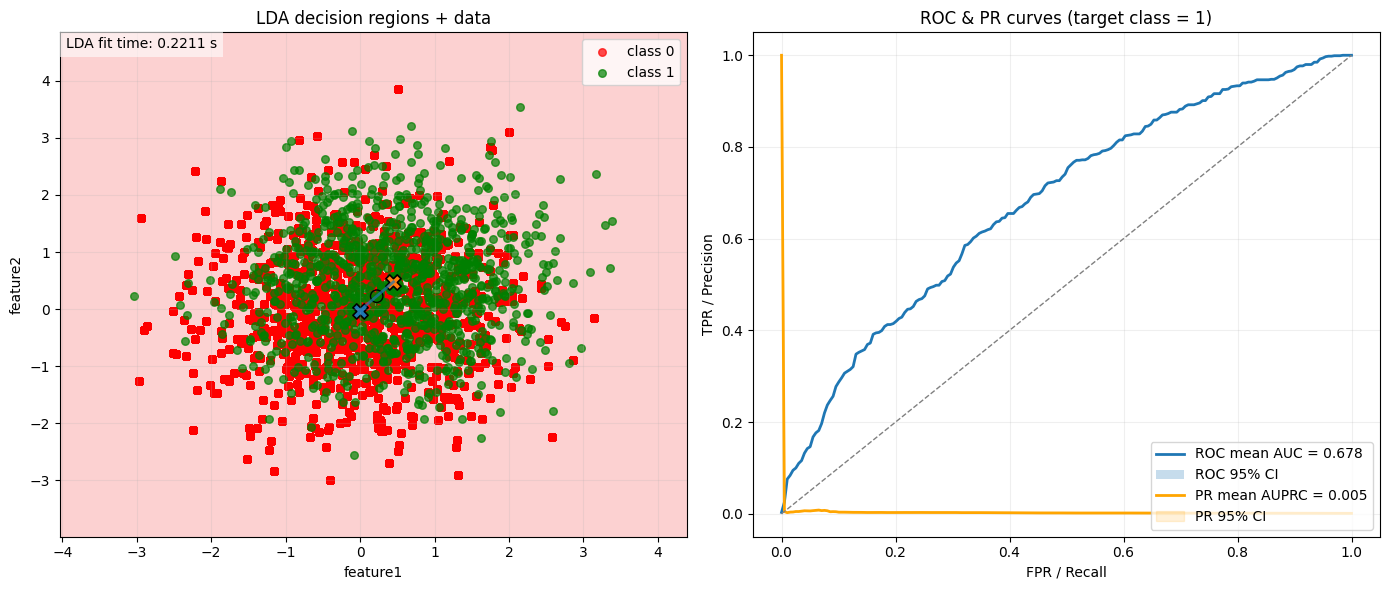


=== Анализ для df10000 (target_class = 1) ===


KeyboardInterrupt: 

In [30]:
for name, dfN in oversampled_datasets.items():
    print(f"\n=== Анализ для {name} (target_class = 1) ===")
    analyze_lda(
        df=dfN,
        class_pair=(0, 1),
        features=('feature1', 'feature2'),
        target_class=1,  # <- новый целевой класс
        n_boot=1500,
        show=True,
        n_jobs=-1
    )


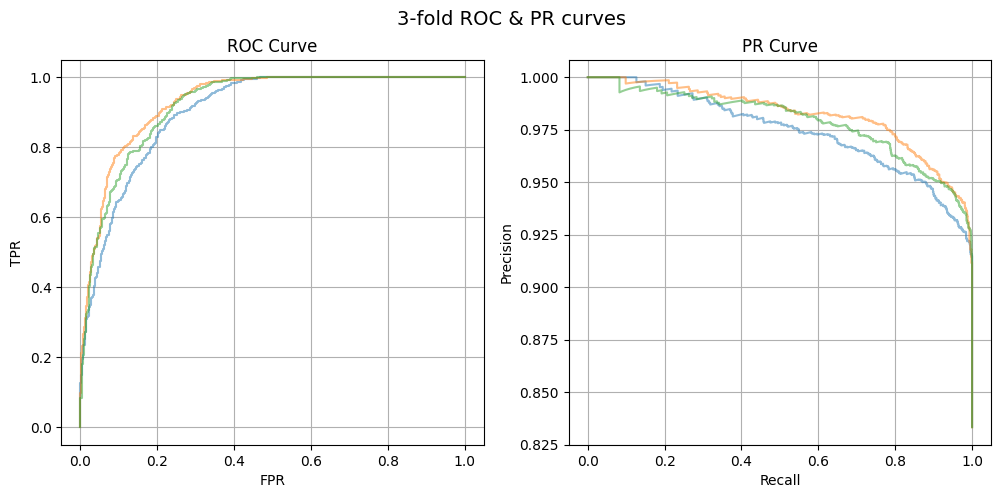



Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 8051.97it/s]


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 6532.13it/s]


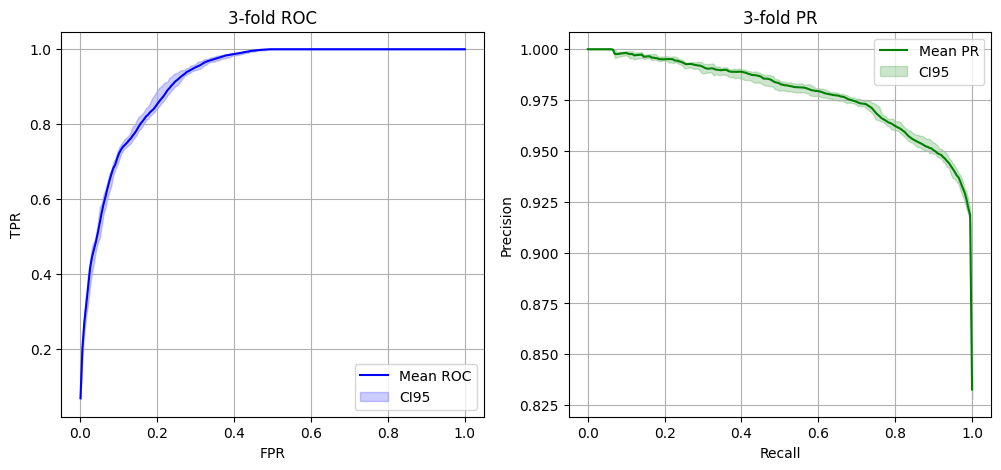

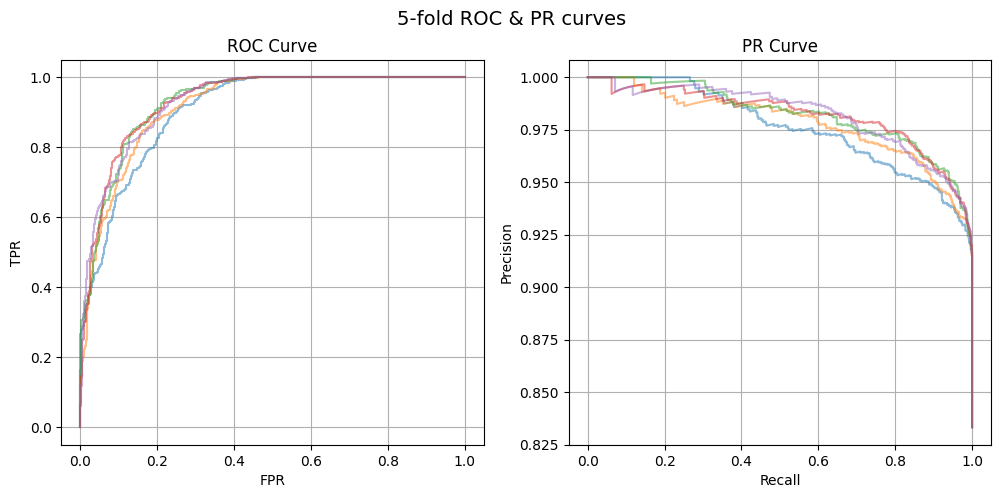



Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 7674.73it/s]



Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 6220.01it/s]


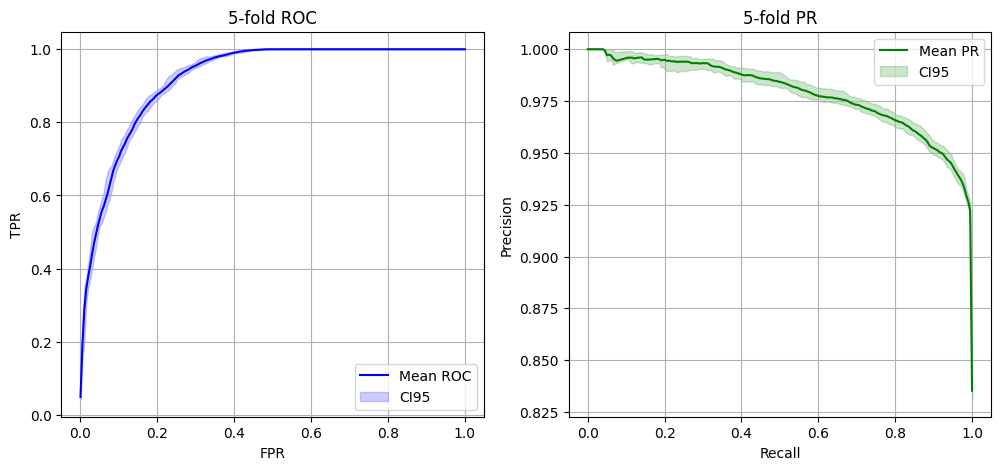

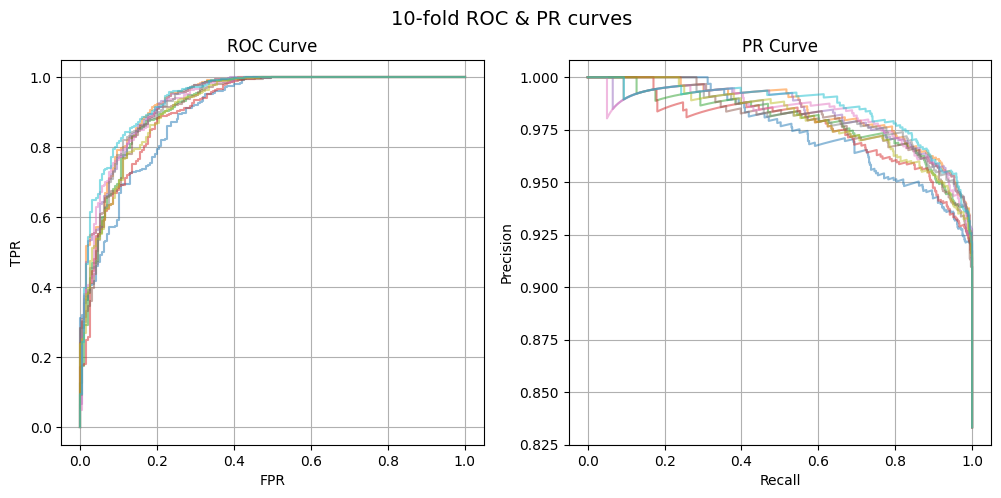



Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 7821.61it/s]



Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 3613.46it/s]


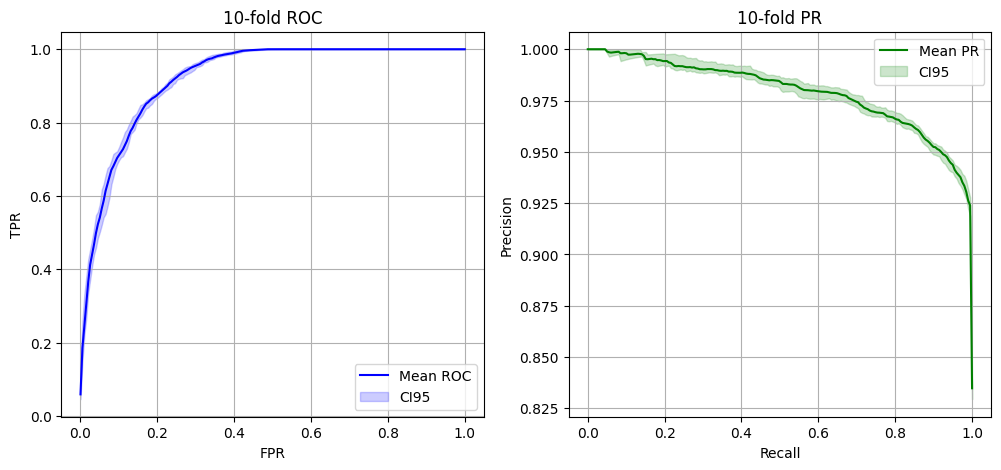

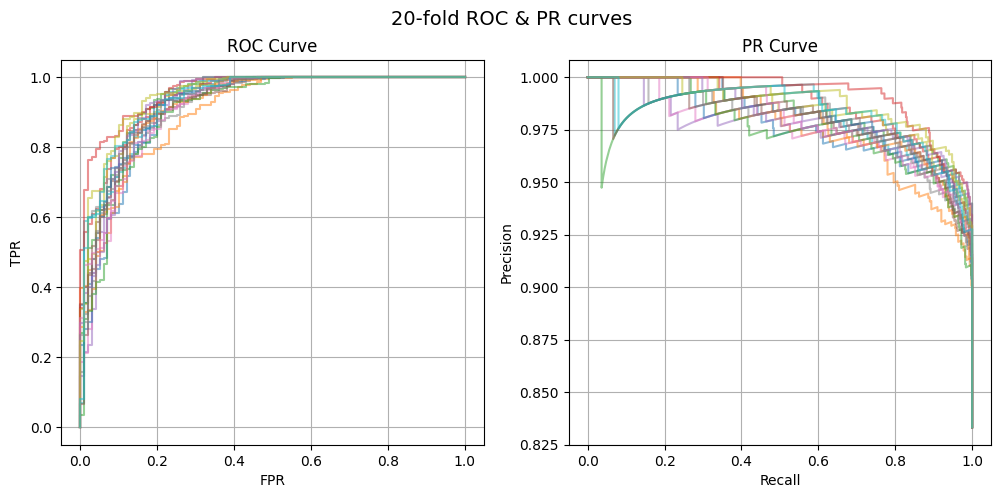



Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 8334.15it/s]



Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 6179.78it/s]


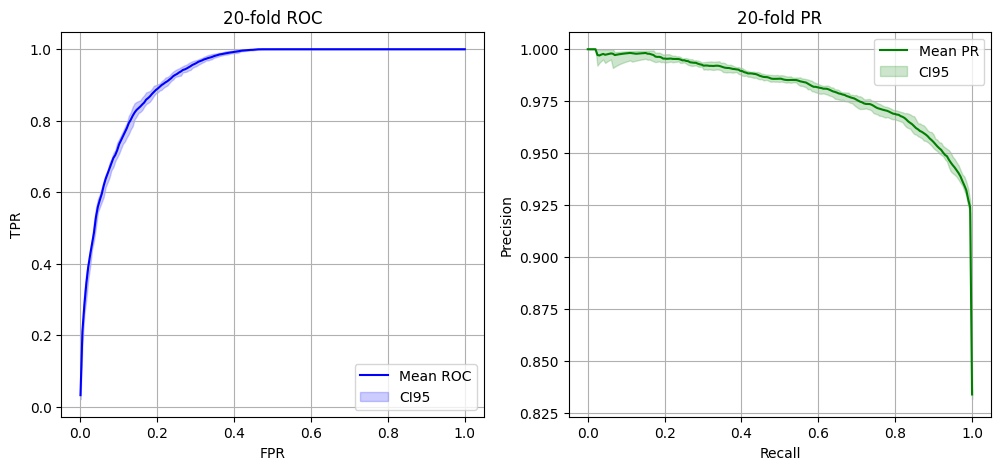

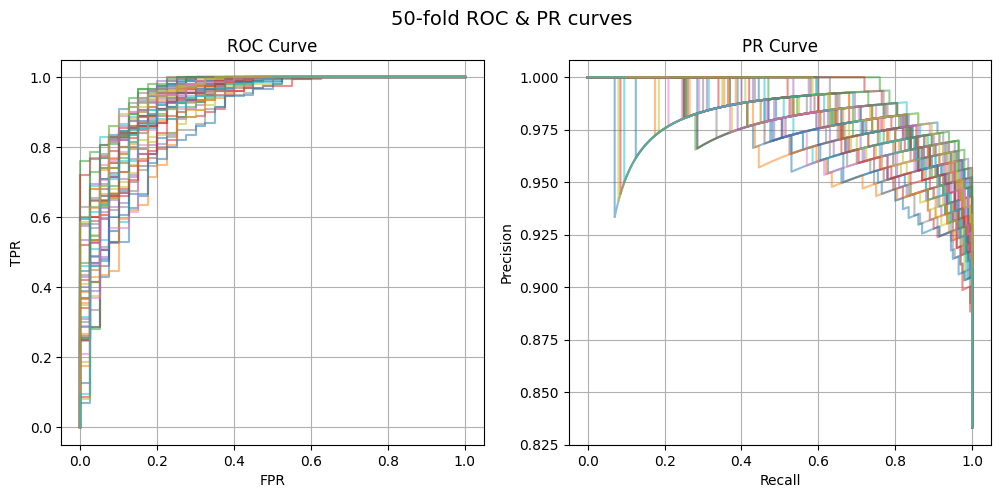



Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 7907.17it/s]



Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 5992.04it/s]


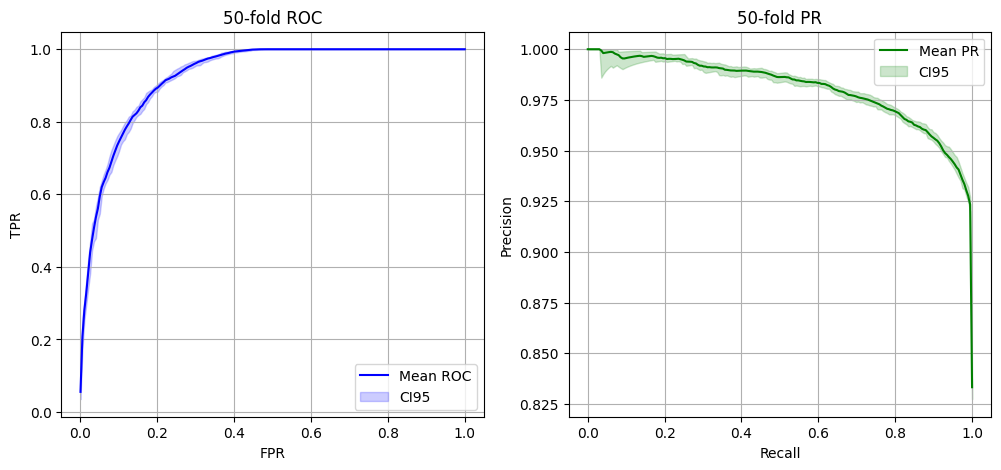

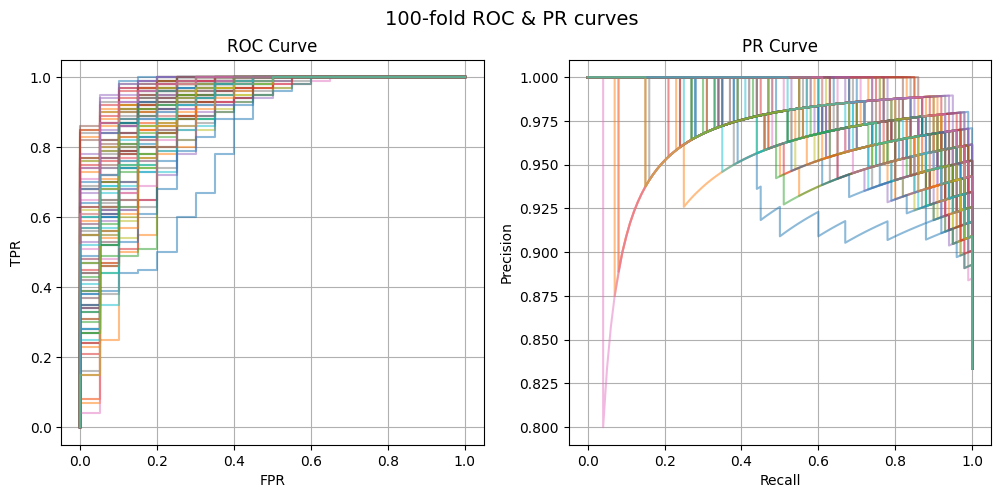



Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 7865.05it/s]



Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 5738.74it/s]


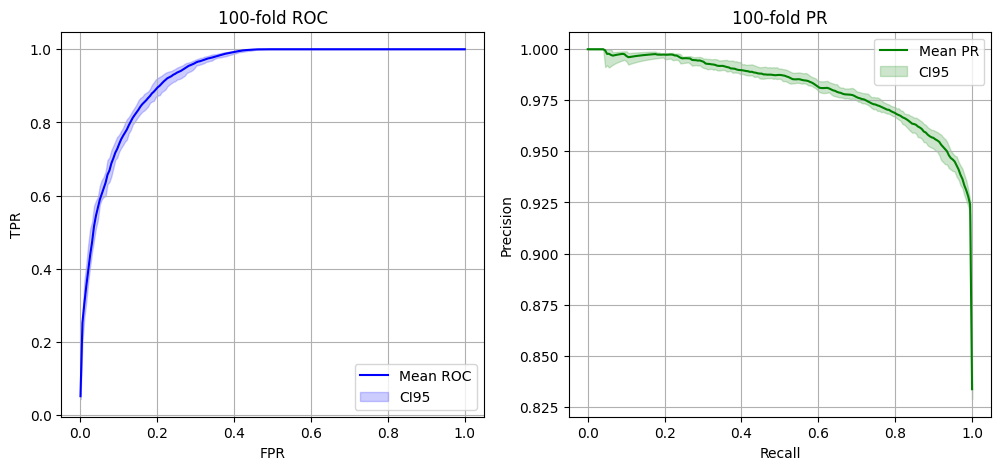

ValueError: 'x' and 'y' must have the same size

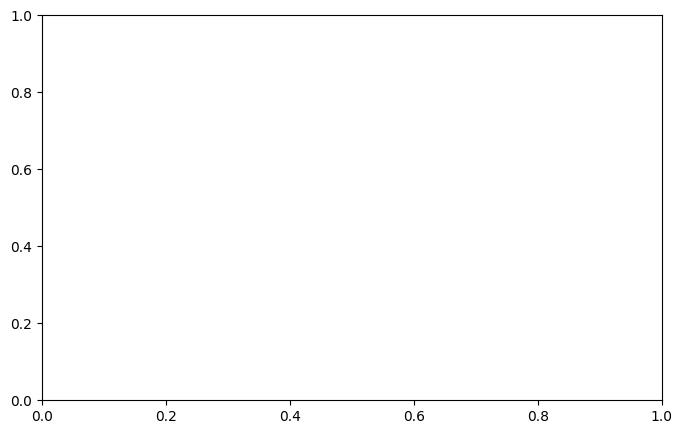

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score

def task8_kfold_roc_pr(df, folds=(3, 5, 10, 20, 50, 100), n_boot=500, random_state=42, n_jobs=-1):
    """
    Для датасета df строит зависимости AUROC и AUPRC от числа фолдов (K-fold CV)
    с доверительными интервалами 95%.
    Также для каждого k строит средние ROC и PR кривые с CI95.
    """
    X = df.drop(columns=['species']).values
    y = df['species'].values
    y_bin = (y == 0).astype(int)  # бинаризация под ROC/PR (0 vs others)

    auroc_means, auprc_means = [], []
    auroc_ci, auprc_ci = [], []

    for k in folds:
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
        y_true_all, y_score_all = [], []

        for train_idx, test_idx in skf.split(X, y_bin):
            lda = LinearDiscriminantAnalysis()
            lda.fit(X[train_idx], y_bin[train_idx])
            try:
                y_score = lda.decision_function(X[test_idx])
            except:
                y_score = lda.predict_proba(X[test_idx])[:, 1]

            y_true_all.extend(y_bin[test_idx])
            y_score_all.extend(y_score)

        y_true_all = np.array(y_true_all)
        y_score_all = np.array(y_score_all)

        # Бутстрэп с ROC и PR
        roc_res = bootstrap_curve(y_true_all, y_score_all,
                                  n_boot=n_boot, curve_type='roc',
                                  random_state=random_state, n_jobs=n_jobs)
        pr_res = bootstrap_curve(y_true_all, y_score_all,
                                 n_boot=n_boot, curve_type='pr',
                                 random_state=random_state, n_jobs=n_jobs)

        # Обработка CI95 (без nan)
        def safe_ci(auc_boot, auc_ci):
            if np.isnan(auc_ci[0]):
                lower = upper = np.mean(auc_boot)
            else:
                lower, upper = auc_ci
            return lower, upper

        roc_lower, roc_upper = safe_ci(roc_res['aucs_boot'], roc_res['auc_ci'])
        pr_lower, pr_upper = safe_ci(pr_res['aucs_boot'], pr_res['auc_ci'])

        auroc_means.append(np.mean(roc_res['aucs_boot']))
        auprc_means.append(np.mean(pr_res['aucs_boot']))
        auroc_ci.append((roc_lower, roc_upper))
        auprc_ci.append((pr_lower, pr_upper))

        # Средние кривые с CI95
        plt.figure(figsize=(12,5))

        # ROC
        plt.subplot(1,2,1)
        plt.plot(roc_res['grid'], np.mean(roc_res['tprs_boot'], axis=0), color='b', label='Mean ROC')
        plt.fill_between(roc_res['grid'], roc_res['tpr_lower'], roc_res['tpr_upper'], color='b', alpha=0.2, label='CI95')
        plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'{k}-fold ROC'); plt.grid(True)
        plt.legend()

        # PR
        plt.subplot(1,2,2)
        plt.plot(pr_res['grid'], np.mean(pr_res['tprs_boot'], axis=0), color='g', label='Mean PR')
        plt.fill_between(pr_res['grid'], pr_res['tpr_lower'], pr_res['tpr_upper'], color='g', alpha=0.2, label='CI95')
        plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(f'{k}-fold PR'); plt.grid(True)
        plt.legend()

        plt.show()

        print(f"{k}-fold: AUROC={np.mean(roc_res['aucs_boot']):.3f}, "
              f"AUPRC={np.mean(pr_res['aucs_boot']):.3f}")

    # Финальная сводная визуализация AUROC/AUPRC ± CI95
    plt.figure(figsize=(8,5))
    plt.errorbar(folds, auroc_means,
                 yerr=[[m-l for (l,m) in auroc_ci],[u-m for (m,u) in auroc_ci]],
                 fmt='o-', capsize=5, label='AUROC ± CI95')
    plt.errorbar(folds, auprc_means,
                 yerr=[[m-l for (l,m) in auprc_ci],[u-m for (m,u) in auprc_ci]],
                 fmt='s--', capsize=5, label='AUPRC ± CI95')
    plt.xscale('log')
    plt.xticks(folds, folds)
    plt.xlabel('K (folds)')
    plt.ylabel('Score')
    plt.title('AUROC и AUPRC при разных K-fold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return pd.DataFrame({
        'folds': folds,
        'AUROC_mean': auroc_means,
        'AUROC_CI95': auroc_ci,
        'AUPRC_mean': auprc_means,
        'AUPRC_CI95': auprc_ci
    })

# === Запуск задания 8 ===
df10 = oversampled_datasets['df10']
results_task8 = task8_kfold_roc_pr(df10, n_boot=1500)
results_task8




Bootstrap progress: 100%|██████████| 500/500 [00:00<00:00, 4388.22it/s]


Bootstrap progress: 100%|██████████| 500/500 [00:00<00:00, 4608.42it/s]


3-fold: AUROC=0.799, AUPRC=0.588




Bootstrap progress: 100%|██████████| 500/500 [00:00<00:00, 4279.10it/s]


Bootstrap progress: 100%|██████████| 500/500 [00:00<00:00, 4498.29it/s]


5-fold: AUROC=0.803, AUPRC=0.593



Bootstrap progress: 100%|██████████| 500/500 [00:00<00:00, 5123.60it/s]

Bootstrap progress: 100%|██████████| 500/500 [00:00<00:00, 5033.39it/s]


10-fold: AUROC=0.812, AUPRC=0.613



Bootstrap progress: 100%|██████████| 500/500 [00:00<00:00, 5196.57it/s]

Bootstrap progress: 100%|██████████| 500/500 [00:00<00:00, 5458.25it/s]


20-fold: AUROC=0.817, AUPRC=0.619




Bootstrap progress: 100%|██████████| 500/500 [00:00<00:00, 4696.69it/s]

Bootstrap progress: 100%|██████████| 500/500 [00:00<00:00, 5390.06it/s]


50-fold: AUROC=0.812, AUPRC=0.613



Bootstrap progress: 100%|██████████| 500/500 [00:00<00:00, 4951.01it/s]


Bootstrap progress: 100%|██████████| 500/500 [00:00<00:00, 4617.66it/s]


100-fold: AUROC=0.811, AUPRC=0.614


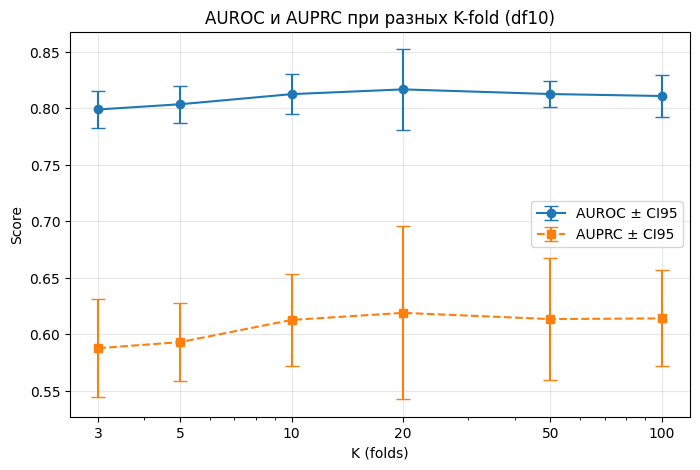

folds  AUROC_mean                                AUROC_CI95  AUPRC_mean  \
0      3    0.798779  (0.7849403171448904, 0.8016361037951256)    0.587539   
1      5    0.803393  (0.7955642595203521, 0.8117803234967007)    0.592941   
2     10    0.812351   (0.7999524395914652, 0.817964993715123)    0.612546   
3     20    0.816537  (0.7941941806120911, 0.8297325403059889)    0.618799   
4     50    0.812428  (0.8054993191181972, 0.8168761354943584)    0.613294   
5    100    0.810679   (0.800482851602397, 0.8192066190941587)    0.613903   

                                 AUPRC_CI95  
0  (0.5609329681245535, 0.6042827080984841)  
1  (0.5718292438880764, 0.6062162812392303)  
2  (0.5898101952176449, 0.6302967080897384)  
3  (0.5700070169938138, 0.6464258255661162)  
4  (0.5803901190402441, 0.6346476827084518)  
5  (0.5944291288387817, 0.6368333808577058)

In [ ]:
results_task8_df1 = task8_kfold_roc_pr(df1)
results_task8_df1



Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 11185.03it/s]


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 11147.59it/s]


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 10112.33it/s]


Bootstrap progress: 100%|██████████| 1500/1500 [00:00<00:00, 10552.84it/s]


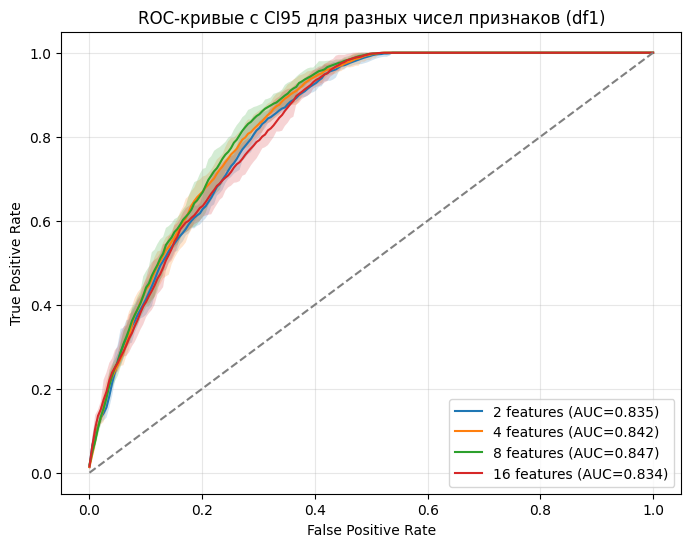

In [39]:
def task9_features_roc(df, features_list=(2, 4, 8, 16), n_boot=500, random_state=42, n_jobs=-1):
    """
    Для df1 строит ROC-кривые с доверительными полосами при разном числе признаков (без PCA).
    """
    X_full = df.drop(columns=['species']).values
    y = df['species'].values
    y_bin = (y == 0).astype(int)

    plt.figure(figsize=(8,6))

    for n_feat in features_list:
        # Берем первые n_feat признаков
        X = X_full[:, :n_feat]

        lda = LinearDiscriminantAnalysis()
        lda.fit(X, y_bin)
        try:
            y_score = lda.decision_function(X)
        except:
            y_score = lda.predict_proba(X)[:, 1]

        roc_res = bootstrap_curve(
            y_bin, y_score, n_boot=n_boot,
            curve_type='roc', random_state=random_state, n_jobs=n_jobs
        )

        plt.plot(
            roc_res['grid'],
            np.mean(roc_res['tprs_boot'], axis=0),
            label=f'{n_feat} features (AUC={np.mean(roc_res["aucs_boot"]):.3f})'
        )
        plt.fill_between(
            roc_res['grid'],
            roc_res['tpr_lower'], roc_res['tpr_upper'],
            alpha=0.2
        )

    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривые с CI95 для разных чисел признаков (df1)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


task9_features_roc(df1, n_boot=1500)
